<a href="https://colab.research.google.com/github/LabSWPP12023S2G2/TPInicial/blob/main/kmeansbetter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-39-1f3a6f66643f>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ref['Cluster'] = kmeans.labels_
<ipython-input-39-1f3a6f66643f>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ref['tsne_x'] = tsne_coordinates[:, 0]
<ipython-input-39-1f3a6f66643f>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

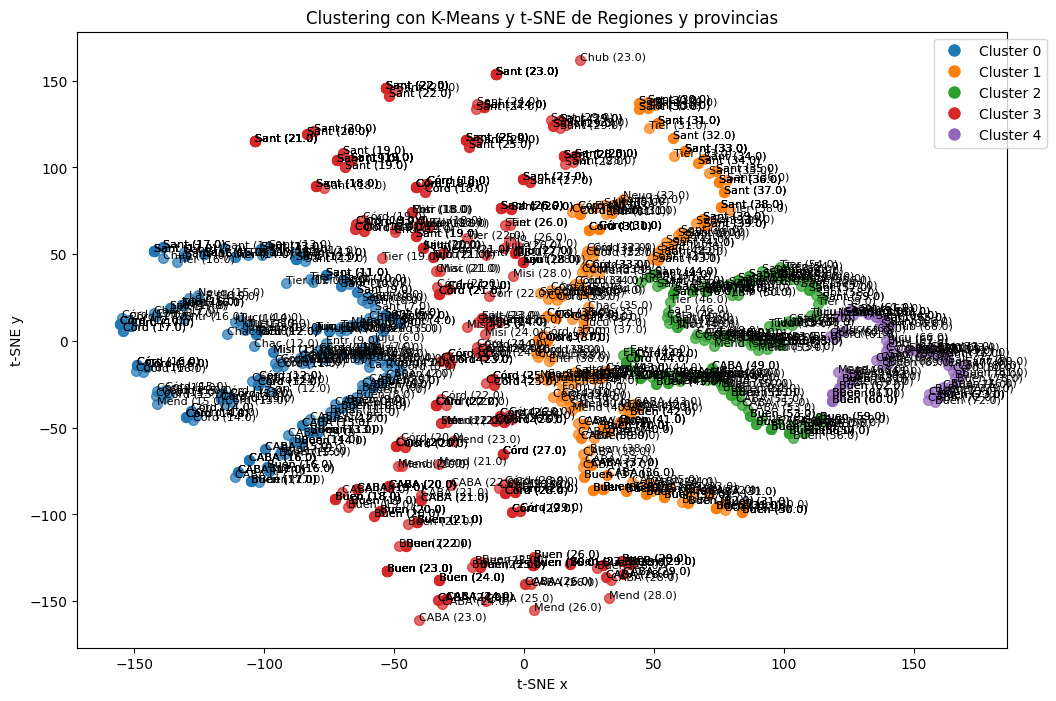

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError

# Cargar los datos (reemplaza esto con la carga de tus datos)
url = 'https://raw.githubusercontent.com/LabSWPP12023S2G2/TPInicial/main/datasetUNC.csv'
data = pd.read_csv(url, delimiter=';')
columns_to_drop = ['SUB PERIODS', 'SEX']
data = data.drop(columns=columns_to_drop)
data = data.dropna(axis=0)
data.drop(data[data['PROVINCE'] == 'Otro'].index, inplace=True)
data.drop(data[data['PROVINCE'] == 'other'].index, inplace=True)

# Asignaciones numéricas para diferentes columnas (usar los valores ya mapeados)
assignment_mapping = {
    'MENTAL DISORDER HISTORY': {'no': 10, 'yes': 0},
    'EDUCATION': {
        'Completed postgraduate': 8,
        'Incomplete tertiary or university': 5,
        'Completed high school': 3,
        'Incomplete postgraduate': 7,
        'Completed tertiary or university': 6,
        'Incomplete high school': 2,
        'Incomplete elementary school': 0,
        'Completed elementary school': 1,
        'Otro': 4
    },
    'SUIC ATTEMPT HISTORY': {'ideation': 5, 'no': 10, 'yes': 0},
    'LIVING WITH SOMEBODY': {'no': 0, 'yes': 10},
    'ECONOMIC INCOME': {'yes': 10, 'no': 0}
}

# Aplicar asignaciones numéricas
for column, mapping in assignment_mapping.items():
    data[column] = data[column].map(mapping)

#ocurrences = data['PROVINCE'].value_counts()
#print(ocurrences)


# Función para asignar una región a cada provincia
def assign_region(province):
    if province in ['Corrientes', 'Chaco', 'Misiones', 'Formosa', 'Entre Ríos']:
        return 'Nordeste-Litoral'
    elif province in ['Tucumán', 'Jujuy', 'Salta', 'Catamarca', 'Santiago del Estero']:
        return 'Noroeste'
    elif province in ['San Luis', 'San Juan', 'Mendoza', 'La Rioja']:
        return 'Cuyo'
    elif province in ['Neuquén', 'Río Negro', 'La Pampa']:
        return 'Patagonia Centro-Norte'
    elif province in ['Tierra del Fuego', 'Santa Cruz', 'Chubut']:
        return 'Patagonia Centro-Sur'
    elif province == 'Santa Fe':
        return 'Santa Fe'
    elif province == 'Buenos Aires provincia':
        return 'Buenos Aires'
    elif province == 'Córdoba':
        return 'Córdoba'
    else:
        return 'CABA'

# Aplicar la función a la columna 'PROVINCE' y guardar el resultado en una nueva columna 'REGION'
data['REGION'] = data['PROVINCE'].apply(assign_region)

# Crear un LabelEncoder para codificar la columna 'REGION'
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['REGION_ENCODED'] = label_encoder.fit_transform(data['REGION'])

# Seleccionar las columnas relevantes para el clustering
data_ref = data[['SUIC RISK', 'REGION_ENCODED']]

# Aplicar K-Means para clasificar las regiones en grupos
kmeans = KMeans(n_clusters=5, n_init=100, random_state=0).fit(data_ref)

# Asignar un color a cada región en base a los clusters
data_ref['Cluster'] = kmeans.labels_

# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_coordinates = tsne.fit_transform(data_ref)
data_ref['tsne_x'] = tsne_coordinates[:, 0]
data_ref['tsne_y'] = tsne_coordinates[:, 1]

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors  # Puedes cambiar 'tab10' a otro mapa de colores según tu preferencia
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
data_ref['PROVINCE'] = data['PROVINCE']
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)


    # Agregar etiquetas de provincias al gráfico usando la columna 'REGION'
    for index, row in cluster_data.iterrows():
        plt.text(row['tsne_x'], row['tsne_y'], f"{row['PROVINCE'][:4]} ({row['SUIC RISK']:.1f})", fontsize=8)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]

# Coloca la leyenda al costado del gráfico
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.title('Clustering con K-Means y t-SNE de Regiones y provincias')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()

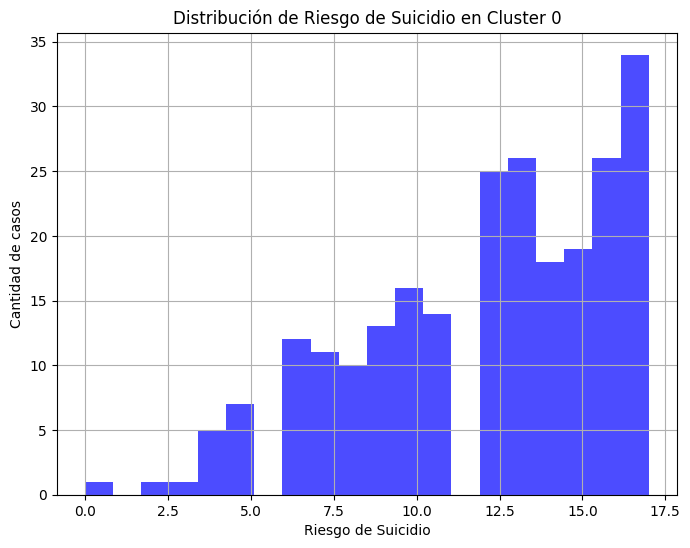

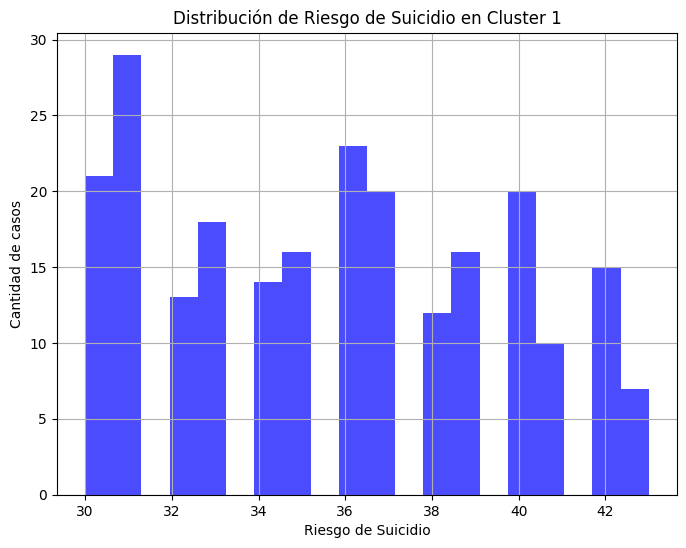

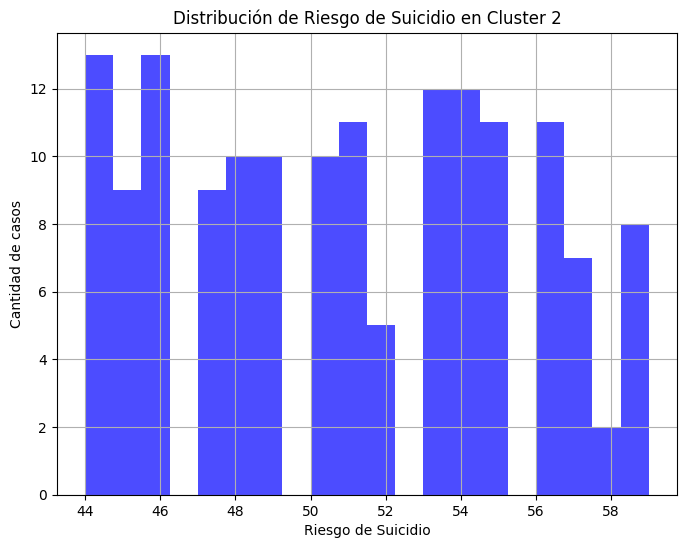

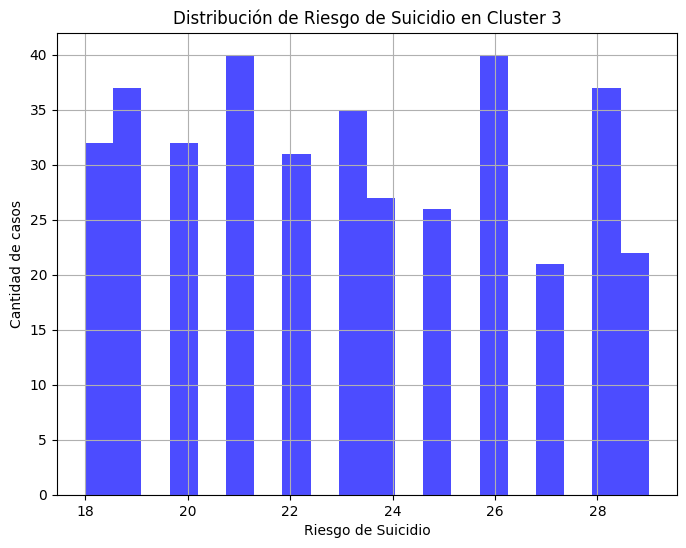

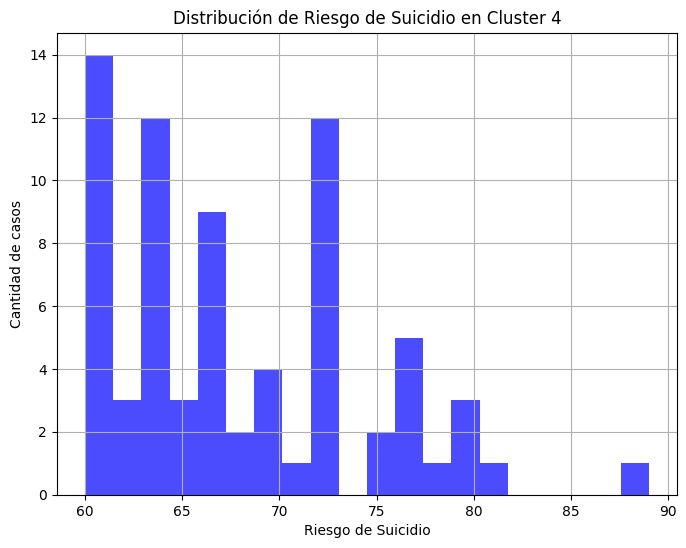

In [42]:
# Crear un gráfico separado para cada cluster
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]

    plt.figure(figsize=(8, 6))
    plt.hist(cluster_data['SUIC RISK'], bins=20, color='blue', alpha=0.7)

    plt.title(f'Distribución de Riesgo de Suicidio en Cluster {cluster}')
    plt.xlabel('Riesgo de Suicidio')
    plt.ylabel('Cantidad de casos')
    plt.grid(True)

    plt.show()

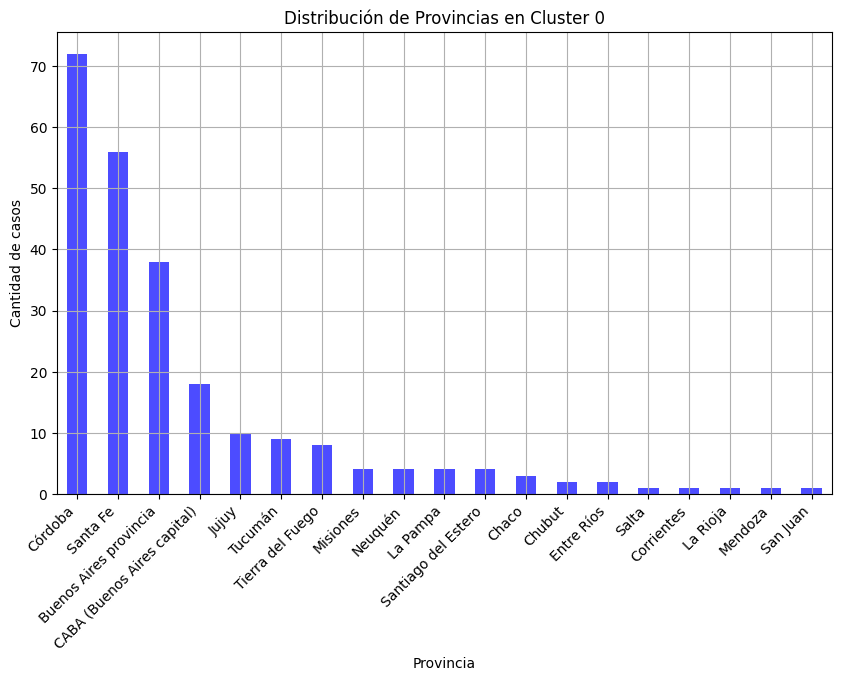

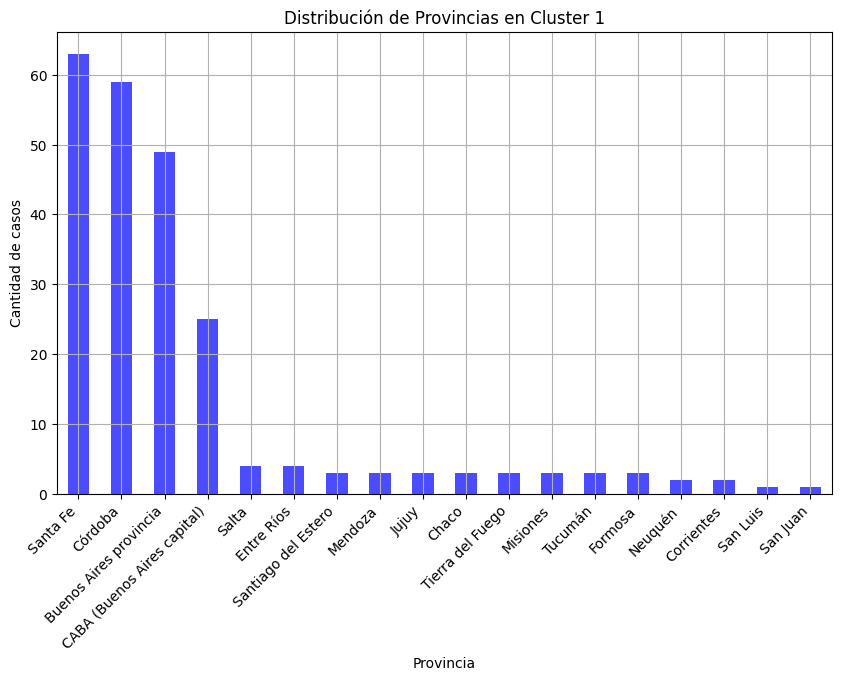

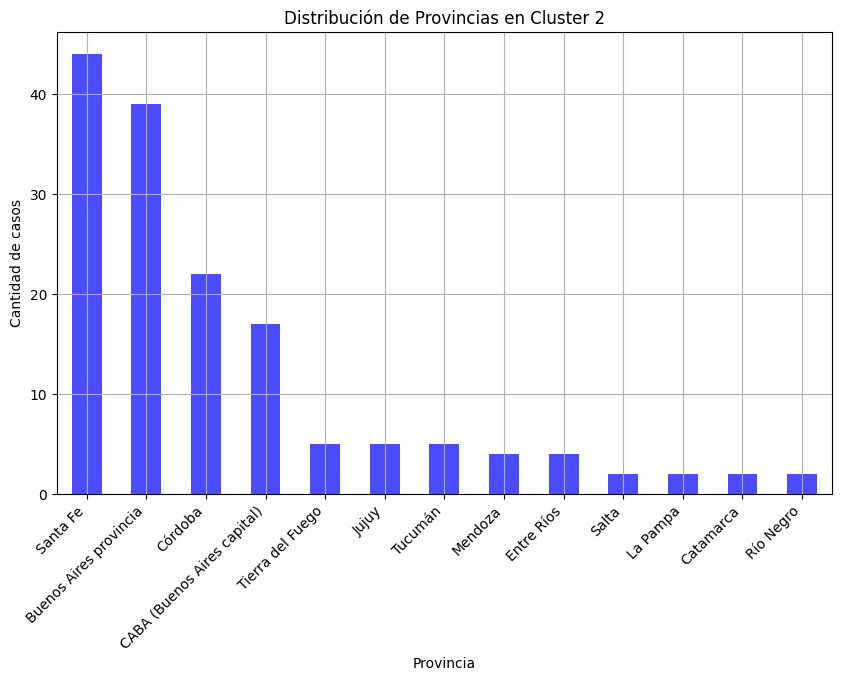

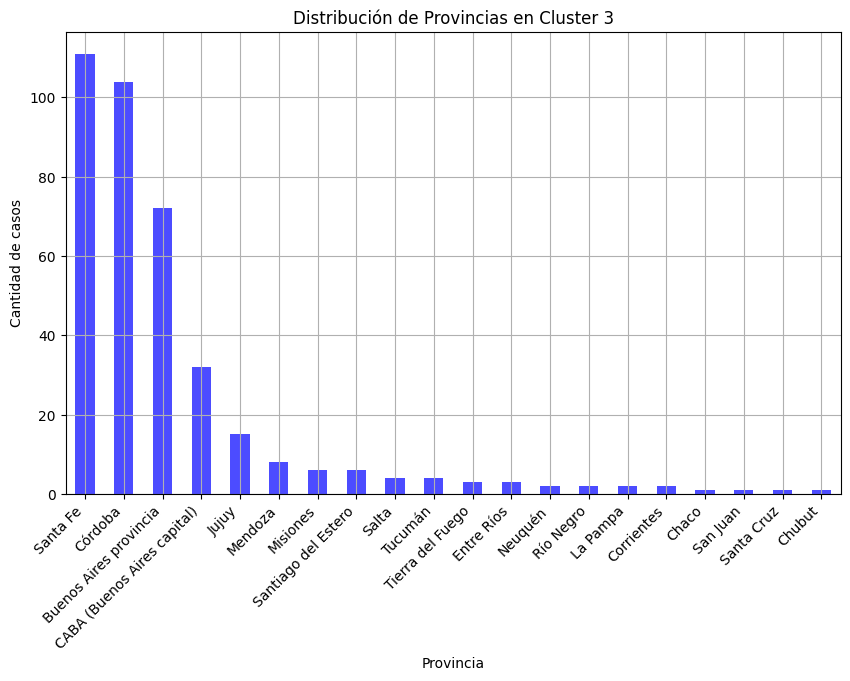

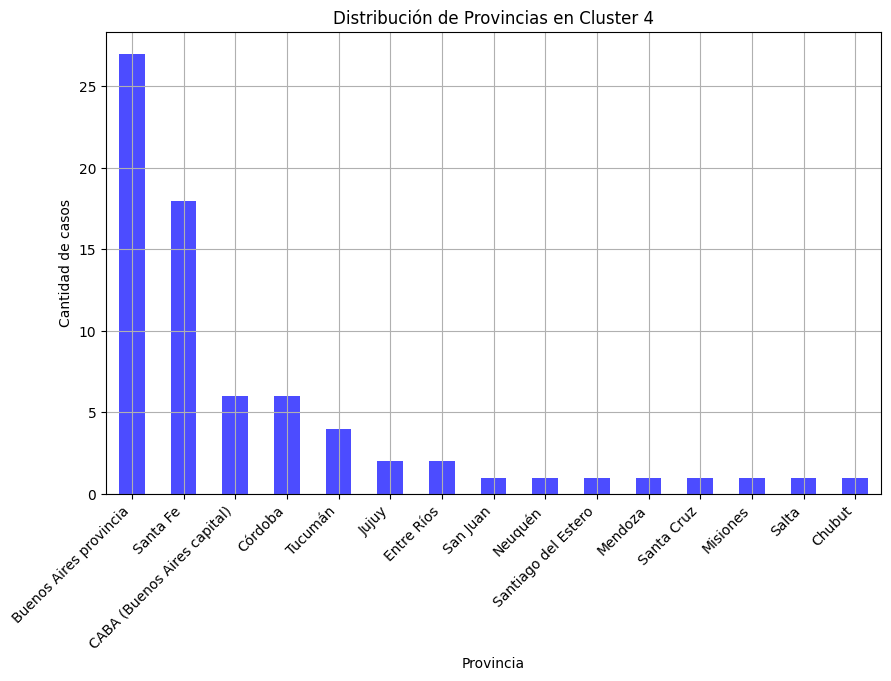

In [80]:
# Crear un gráfico de barras apilado para cada cluster
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    province_counts = cluster_data['PROVINCE'].value_counts()

    plt.figure(figsize=(10, 6))
    province_counts.plot(kind='bar', color='blue', alpha=0.7)

    plt.title(f'Distribución de Provincias en Cluster {cluster}')
    plt.xlabel('Provincia')
    plt.ylabel('Cantidad de casos')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    plt.show()

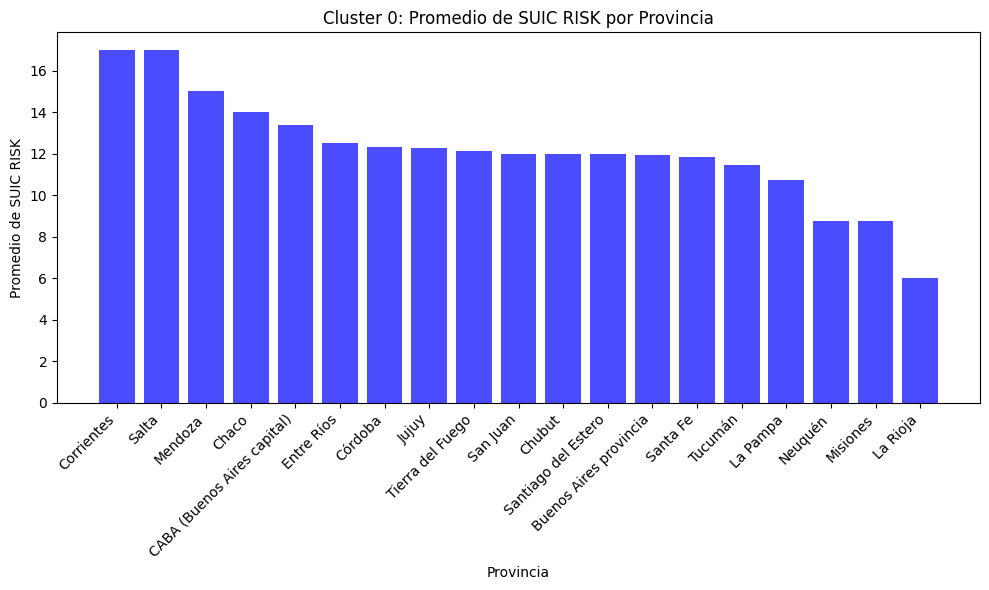

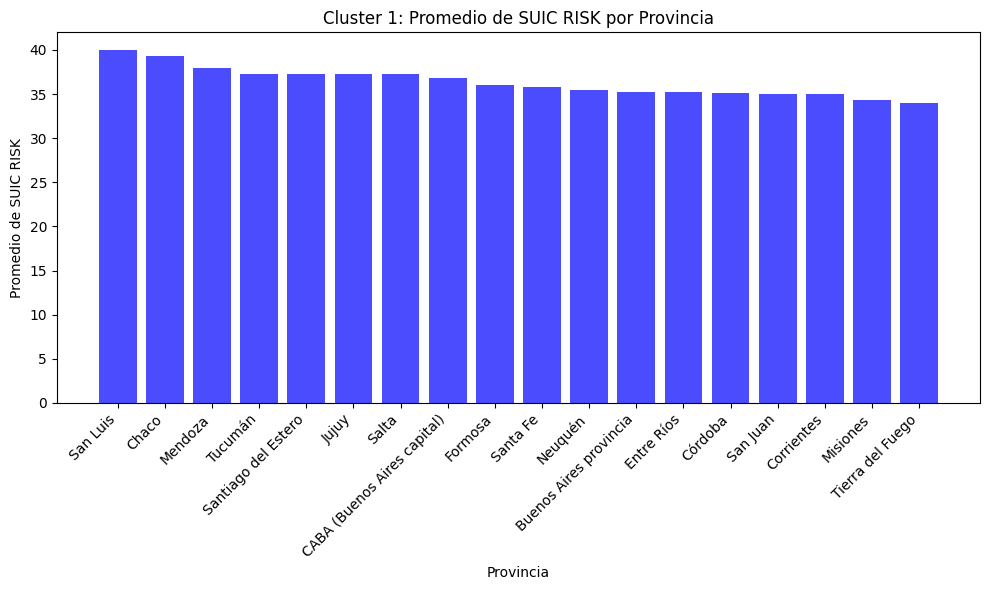

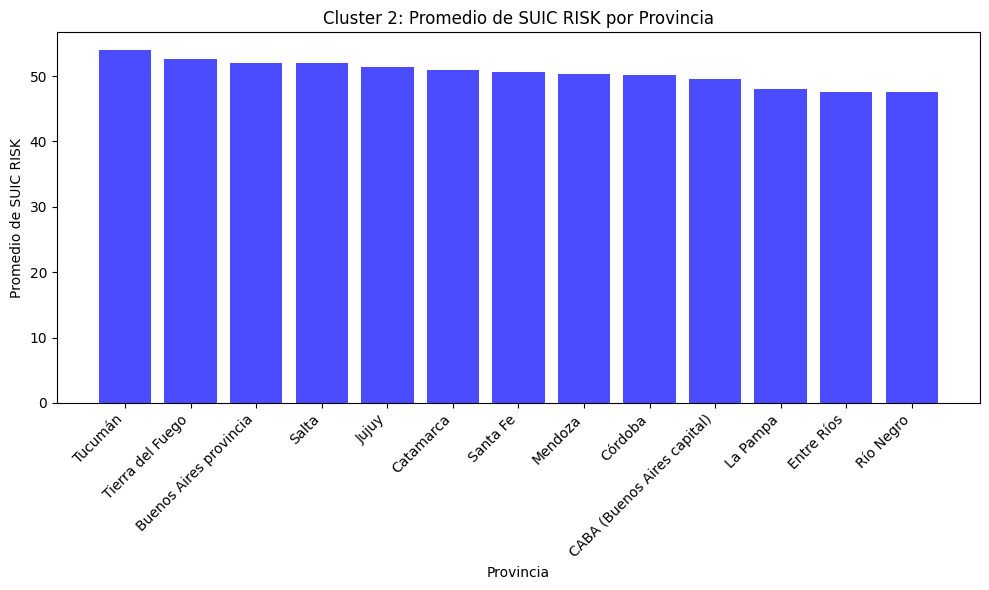

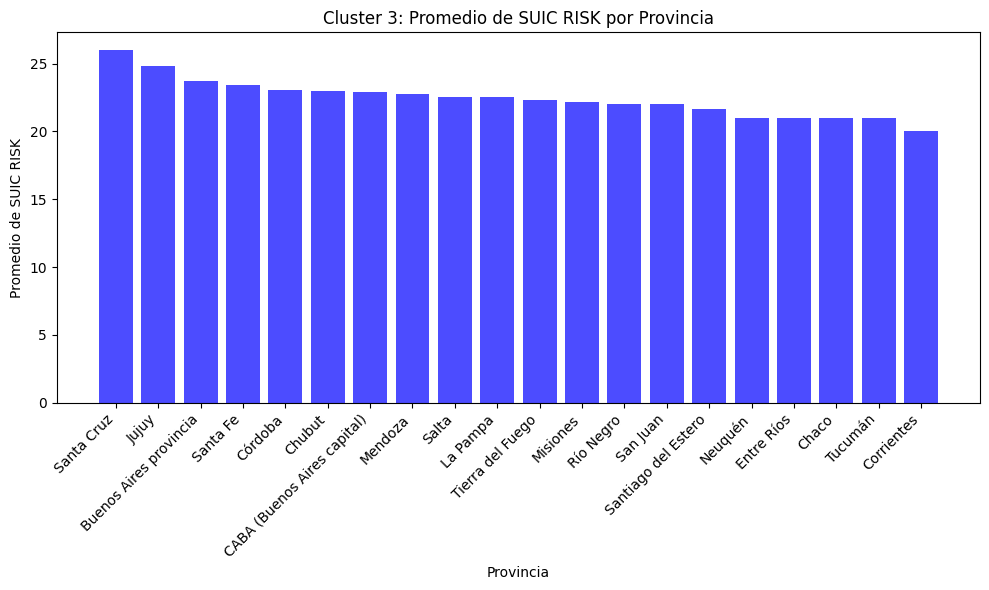

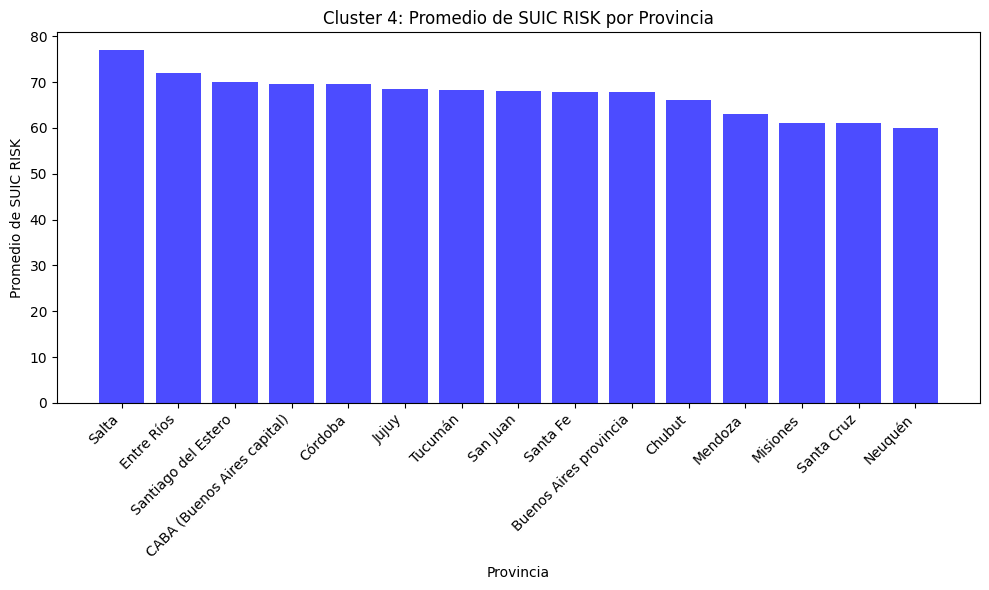

In [55]:
# Calcular el promedio de SUIC RISK por PROVINCE en cada cluster
cluster_averages = {}
for cluster in range(len(np.unique(kmeans.labels_))):
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    province_averages = cluster_data.groupby('PROVINCE')['SUIC RISK'].mean()
    cluster_averages[cluster] = province_averages

# Crear un gráfico por cluster
for cluster, province_averages in cluster_averages.items():
    plt.figure(figsize=(10, 6))
    province_averages = province_averages.sort_values(ascending=False)
    plt.bar(province_averages.index, province_averages.values, color='blue', alpha=0.7)
    plt.title(f'Cluster {cluster}: Promedio de SUIC RISK por Provincia')
    plt.xlabel('Provincia')
    plt.ylabel('Promedio de SUIC RISK')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

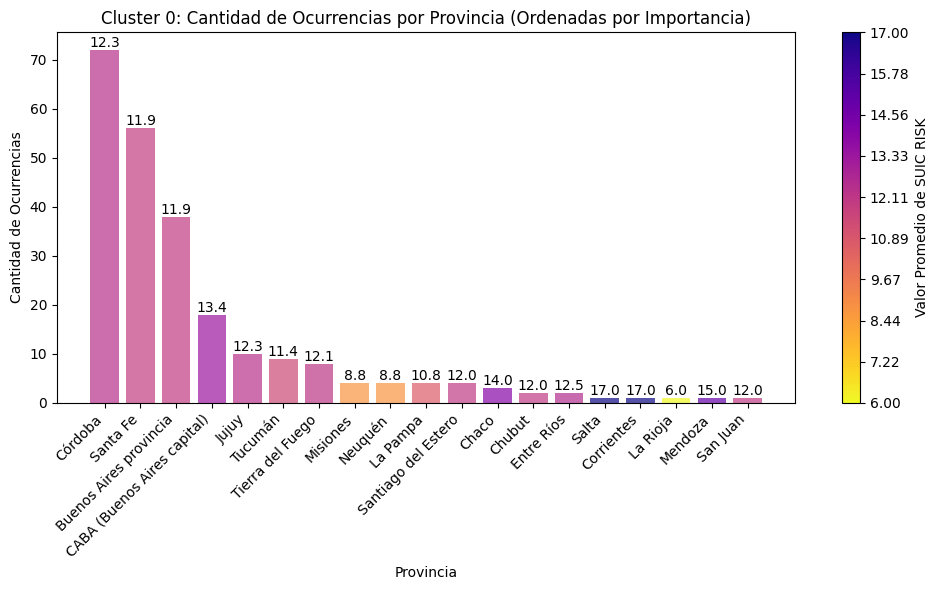

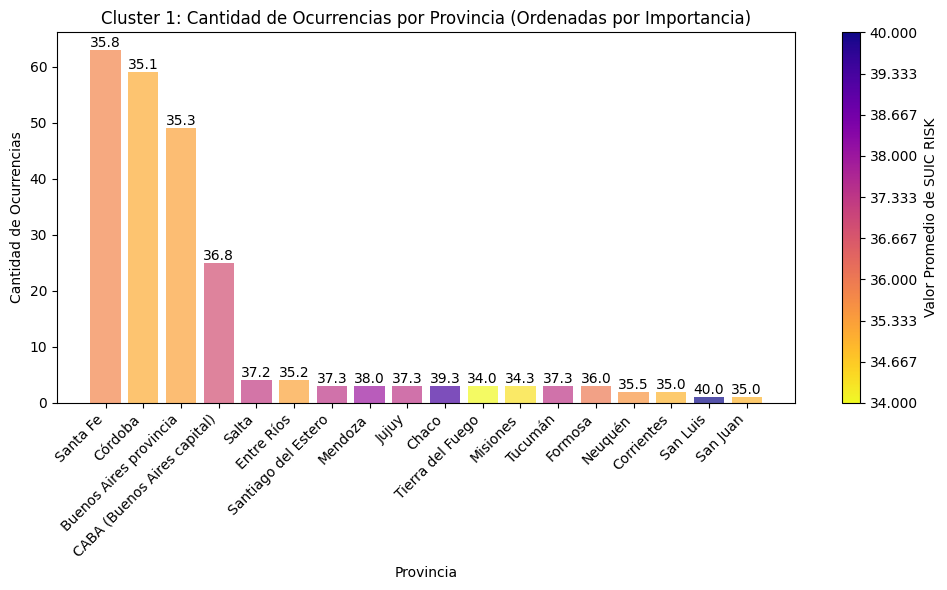

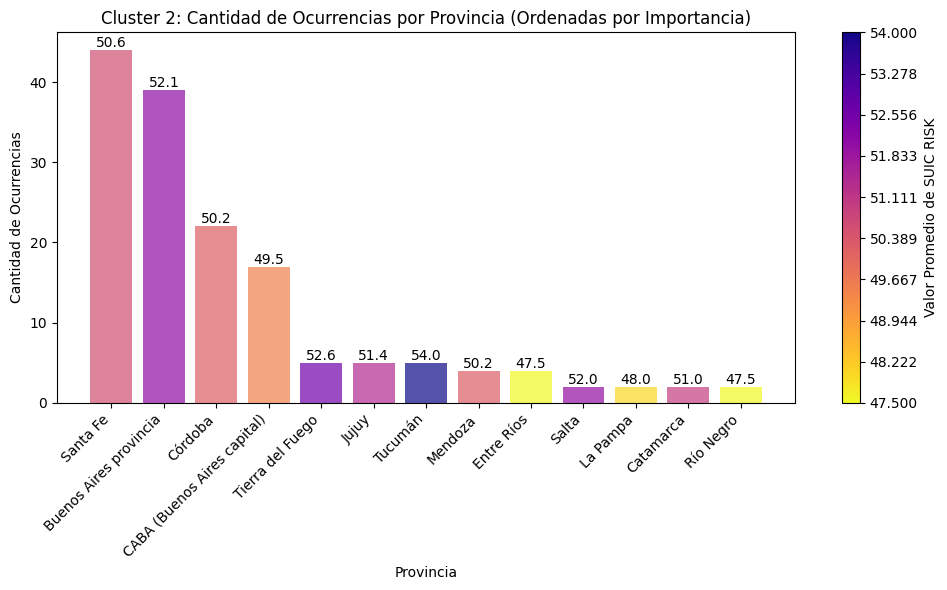

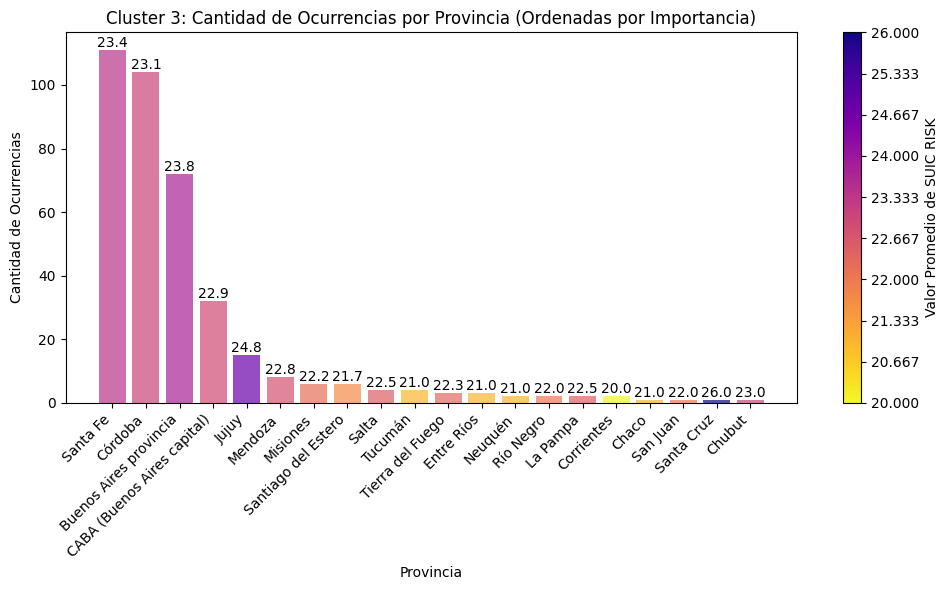

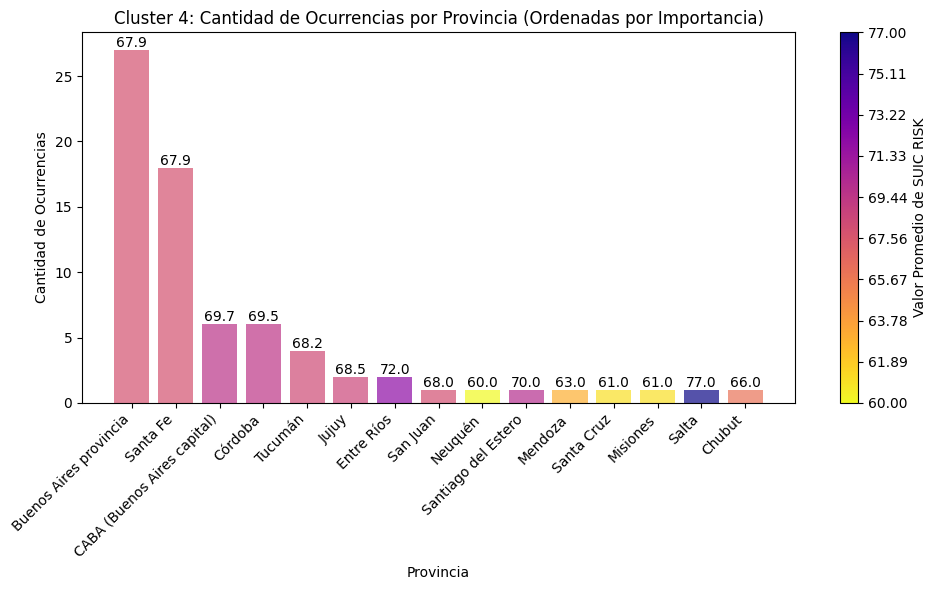

In [76]:
import matplotlib.pyplot as plt
import matplotlib as cm

# Crear un gráfico por cluster mostrando la cantidad de ocurrencias por provincia (ordenadas por importancia)
unique_clusters = np.unique(kmeans.labels_)
for cluster in unique_clusters:
    cluster_data = data_ref[data_ref['Cluster'] == cluster]
    province_avg_suic_risk = {}
    province_counts = cluster_data['PROVINCE'].value_counts()

    for province in province_counts.index:
        province_avg_suic_risk[province] = cluster_data[cluster_data['PROVINCE'] == province]['SUIC RISK'].mean()

    # Ordenar las provincias por la cantidad de ocurrencias
    sorted_provinces = sorted(province_counts.index, key=lambda x: province_counts[x], reverse=True)

    plt.figure(figsize=(10, 6))
    norm = plt.Normalize(min(province_avg_suic_risk.values()), max(province_avg_suic_risk.values()))
    cmap = cm.colormaps.get_cmap('plasma_r')

    bars = plt.bar(range(len(sorted_provinces)), province_counts[sorted_provinces], color=[cmap(norm(province_avg_suic_risk[province])) for province in sorted_provinces], alpha=0.7)
    plt.xticks(range(len(sorted_provinces)), sorted_provinces, rotation=45, ha='right')
    plt.title(f'Cluster {cluster}: Cantidad de Ocurrencias por Provincia (Ordenadas por Importancia)')
    plt.xlabel('Provincia')
    plt.ylabel('Cantidad de Ocurrencias')

    # Añadir etiquetas con el valor promedio de SUIC RISK
    for bar, province in zip(bars, sorted_provinces):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{province_avg_suic_risk[province]:.1f}', ha='center', va='bottom')

    # Añadir barra de color para indicar valores de SUIC RISK
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Agregar el eje (ax) para la barra de colores
    cbar = plt.colorbar(sm, ax=plt.gca(), ticks=np.linspace(min(province_avg_suic_risk.values()), max(province_avg_suic_risk.values()), num=10))
    cbar.set_label('Valor Promedio de SUIC RISK')

    plt.tight_layout()
    plt.show()
